# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Этапы выполнения:</b> 
1. Загрузка данных, анализ общей информации;
2. Предобработка данных: 
* преобразование типов данных;
* удаление или замена пропусков и дубликатов.
3. Исследовательский анализ данных - описание и визуализация общей информации:
* статистический анализ всех признаков;
* построение графиков для каждого признака
4. Корреляционный анализ признаков:
* расчет коэффициентов корреляции между всеми признаками.
5. Подготовка выборки для обучения моделей.
6. Обучение моделей:
* LightGBM;
* Обучение прочих моделей;
* анализ времени обучения, времени предсказания и качества моделей;
* выбор лучшей модели.
7. Проверка качества лучшей модели на тестовой выборке.
9. Формирование итогового вывода. 


<b>Описание данных:</b> 
Файл autos.csv содержит данные об автомобилях и их стоимости.
Описание данных: 
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя.


## Подготовка данных

### Загрузка данных 

In [1]:
#импорт библиотек и настройка отображения 
!pip install optuna -q

!pip install  phik==0.10.0 -q

!pip install -U scikit-learn -q

# !pip install lightgbm -q 

In [2]:
#импорт библиотек и настройка отображения 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from sklearn.model_selection import GridSearchCV 

from optuna.integration import OptunaSearchCV
from optuna import distributions

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

import phik

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.2f}'.format

RANDOM_STATE = 73
TEST_SIZE = 0.25

from sklearn.metrics import mean_squared_error 

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [3]:
# загрузка данных
autos = pd.read_csv('autos.csv')

In [4]:
# посмотрим на содержание
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
#функция для расчета количесства строк в столбце, количество заполненных и доли пропусков
def df_info(df, str1 = "-------\n", str2 = "\n\n") :
    print(str1)
    df_size = df.size
    not_na_count = df.notna().sum()
    na_count = df.isna().sum()
    dublicated = df.duplicated().sum()
    
    if df_size == na_count:
        print('Данные отсутствуют')
    elif df_size == 0 :
        print('Данные отсутствуют')
    else:
        print(f"size: {df_size}")
        print(f"na_count: {na_count}")
        print(f"not_na_count: {not_na_count}")
        print(f"na_ratio: {(na_count / df_size):.2f}") 
        print(f"duplicated: {dublicated}") 
        print(f"duplicated_ratio: {(dublicated / df_size):.2f}") 
    print(str2)

In [6]:
#создаем функцию для применения предыдущей функции к каждому столбцу 
def data_info (data, col_name):
    print(col_name)
    df_info(data[col_name])

In [7]:
#смотрим результат для autos
for el in autos.columns:
    data_info(autos, el)
print(autos.info())
print('Дублей: ', autos.duplicated().sum())
print(autos.isna().sum())

DateCrawled
-------

size: 354369
na_count: 0
not_na_count: 354369
na_ratio: 0.00
duplicated: 83195
duplicated_ratio: 0.23



Price
-------

size: 354369
na_count: 0
not_na_count: 354369
na_ratio: 0.00
duplicated: 350638
duplicated_ratio: 0.99



VehicleType
-------

size: 354369
na_count: 37490
not_na_count: 316879
na_ratio: 0.11
duplicated: 354360
duplicated_ratio: 1.00



RegistrationYear
-------

size: 354369
na_count: 0
not_na_count: 354369
na_ratio: 0.00
duplicated: 354218
duplicated_ratio: 1.00



Gearbox
-------

size: 354369
na_count: 19833
not_na_count: 334536
na_ratio: 0.06
duplicated: 354366
duplicated_ratio: 1.00



Power
-------

size: 354369
na_count: 0
not_na_count: 354369
na_ratio: 0.00
duplicated: 353657
duplicated_ratio: 1.00



Model
-------

size: 354369
na_count: 19705
not_na_count: 334664
na_ratio: 0.06
duplicated: 354118
duplicated_ratio: 1.00



Kilometer
-------

size: 354369
na_count: 0
not_na_count: 354369
na_ratio: 0.00
duplicated: 354356
duplicated_ratio: 

На первый взгляд в данных много пропусков, есть полные дубли, есть несоответствие в типах данных. 
Разберемся с этим в следующих шагах.

### Предобработка данных

Для начала приведем названия колонок в порядок, чтобы было удобнее с ними работать. 

In [9]:
import re 

autos.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in autos.columns]
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [10]:
# проверия, что все сработало
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [11]:
#посмотрим на уникальные значения в каждом столбце с категориальными данными таблицы autos
cat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

for t in autos.columns:
    if t in cat_col:
        print(t, '\n')
        print(autos[t].value_counts())

vehicle_type 

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64
gearbox 

manual    268251
auto       66285
Name: gearbox, dtype: int64
model 

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64
fuel_type 

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64
brand 

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeo

In [12]:
autos['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Судя по всему, категориальные данные заполнены нормально, без дублей.

Для удобства приведем данные в столбце repaired к типу 1/0. 

Помним о пропусках в этом столбце. 
Допущение: если данные о ремонте не заполнены, предположим, что ремонта не было.

In [13]:
# преобразовываем данные в столбце repaired в булиевый тип
def repaired_new(row):
    if row['repaired'] == 'yes':
        return 1
    else:
        return 0
    
#доабавление данных в новый столбец 
autos['repaired_new'] = autos.apply(repaired_new, axis=1)

In [14]:
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,repaired_new
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,1
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,0


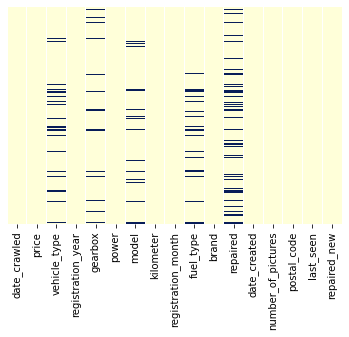

In [15]:
# посмотрим наглядно, как обстоят дела с пропусками
sns.heatmap(autos.isna(), yticklabels=False, cbar=False, cmap="YlGnBu");

Пропусков многовато. Посмотрим на каждый столбец с пропусками.

Попробуем разобраться с типом кузова. На примере volkswagen golf выясним, есть ли заполненные данные, чтобы заполнить модой по бренду/модели. 

In [16]:
autos[(autos['brand'] == 'volkswagen') & (autos['model'] == 'golf')].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,repaired_new
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,0
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,0
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,0
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50,0


Видим, что гольфы выпускались с разным типом кузова, при этом коробка у них одинаковая в основном. Тогда так: проспуски в vehicle_type заполним заглушкой "unknown", а коробку заполним модой. Кстати, fuel_type в этом примере тоже одинаковый для сочетания бренд/модель, здесь тоже подойдет мода. 

In [17]:
# ставим заглушку на столбце vehicle_type
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')

In [18]:
# проверяем, что пропусков не осталось
autos['vehicle_type'].isna().sum()

0

Если за рабочее сочетание мы берем бренд + модель, важно, чтобы пропусков здесь не было. 
С брендом все хорошо, но в модели есть пропуски. Посмотрим, сколько таких пропусков - сможем ли мы их удалить.

In [19]:
autos['model'].isna().sum() / autos['brand'].count()

0.055605879746817584

Все-таки удалим эти пропуски, их менее 6%, при этом значения в этом столце влияют на качество заполнеиня пропусков в прочих. 

In [20]:
autos = autos[autos['model'].isna() == False]
autos.shape

(334664, 17)

In [21]:
autos['brand_model'] = autos['brand'] + ' / ' + autos['model']
autos.sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,repaired_new,brand_model
295464,2016-04-04 13:37:44,14800,convertible,2008,manual,105,a3,90000,10,gasoline,audi,no,2016-04-04 00:00:00,0,21435,2016-04-06 14:45:04,0,audi / a3
222646,2016-03-20 22:47:36,1650,small,2002,NaN,0,fortwo,125000,6,petrol,smart,no,2016-03-20 00:00:00,0,79110,2016-04-07 08:45:15,0,smart / fortwo
4009,2016-04-04 15:40:09,8500,sedan,2009,manual,140,civic,60000,11,petrol,honda,no,2016-04-04 00:00:00,0,4357,2016-04-06 16:47:25,0,honda / civic
214693,2016-03-20 21:56:33,10500,wagon,2006,manual,150,c_klasse,150000,8,gasoline,mercedes_benz,NaN,2016-03-20 00:00:00,0,33175,2016-04-07 07:16:39,0,mercedes_benz / c_klasse
263148,2016-03-30 12:36:39,3250,coupe,1995,manual,193,3er,150000,6,petrol,bmw,no,2016-03-30 00:00:00,0,57076,2016-04-01 06:16:18,0,bmw / 3er


In [22]:
# запоняем пропуски в gearbox 
for t in autos['brand_model'].unique():
    gear_mode = autos.loc[(autos['brand_model'] == t) & ~(autos['gearbox'].isna())]['gearbox'].mode().values[0]
    autos.loc[(autos['brand_model'] == t) & (autos['gearbox'].isna()), 'gearbox'] = gear_mode

In [23]:
autos['gearbox'].isna().sum()

0

Попробуем тип топлива заполнить медианным значением по бренд+модель
Кончено, каждая модель может предполагать несколько вариантов + возможны индивидуальные решения и доработки, но все же наиболее частое значение в модели кажется лучшим решением, чем самое частое в выборке или просто заглушка

In [24]:
# запоняем пропуски в fuel_type 
for t in autos['brand_model'].unique():
    fuel_type_mode = autos.loc[(autos['brand_model'] == t) & ~(autos['fuel_type'].isna())]['fuel_type'].mode().values[0]
    autos.loc[(autos['brand_model'] == t) & (autos['fuel_type'].isna()), 'fuel_type'] = fuel_type_mode

In [25]:
autos['fuel_type'].isna().sum()

0

In [26]:
print(autos.isna().sum())

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              62100
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
repaired_new              0
brand_model               0
dtype: int64


Наконец, с пропусками разобрались.

Подготовим выбоку к дальнейшим исследованиям - удалим ненужные столбцы:
* repaired - он у нас заменен на repaired_new;
* date_crawled - неинформативен. Стоимость не будет зависеть от даты скачивания анкеты;
* date_created - аналогично date_crawled
* number_of_pictures - конечно, от количества фото зависит наличие звонков от покупателей и скорость продажи. Однако наш целевой признак - цена, а она от фотографий не зависит 
* postal_code - аналогично date_crawled
* lastseen - аналогично date_crawled

brand_model сможем использовать как дополнительный признак в моделях, его пока оставим

In [27]:
autos = autos.drop(['repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

Красота.

Посмотрим на распределение значений и корреляцию в признаках.

### Исследовательский анализ данных

In [28]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        334664 non-null  object
 1   price               334664 non-null  int64 
 2   vehicle_type        334664 non-null  object
 3   registration_year   334664 non-null  int64 
 4   gearbox             334664 non-null  object
 5   power               334664 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           334664 non-null  int64 
 8   registration_month  334664 non-null  int64 
 9   fuel_type           334664 non-null  object
 10  brand               334664 non-null  object
 11  repaired_new        334664 non-null  int64 
 12  brand_model         334664 non-null  object
dtypes: int64(6), object(7)
memory usage: 35.7+ MB


In [29]:
#определим количественные и категориальные столбцы
col = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']
cat_col = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired_new']

In [30]:
#сделаем графики в желто-зеленой гамме
colors=['chartreuse', 'green', 'lawngreen', 'lightgreen', 'limegreen', 'mediumseagreen', 'mediumspringgreen', 
       'palegreen', 'springgreen', 'yellowgreen', 'greenyellow', 'lime', 'yellow', 'gold']

In [31]:
#сооздадим функцию, которая поможет нам с графиками
def visual (df, col):
    df[col].plot(
        kind='hist',
        title=col,
        alpha=0.5,
        color=np.random.choice(colors)
    )
    plt.xlabel(col)
    plt.ylabel('Количество авто');
    plt.show()
    
    df[col].plot(
    kind='box',
    title=col,
    color=np.random.choice(colors)
    );
    plt.show()

In [32]:
#сооздадим функцию, которая поможет нам с графиками по категориальным данным 
def visual_cat (df, col):
    ax = sns.countplot(x=col, data=df, color=np.random.choice(colors))
    plt.xlabel(col)
    plt.ylabel('Количество авто')
    plt.title(col)
    plt.show()

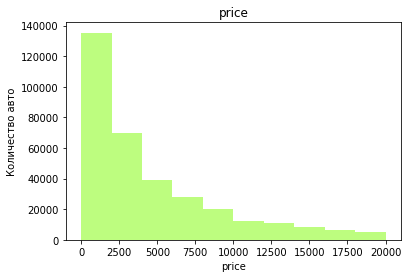

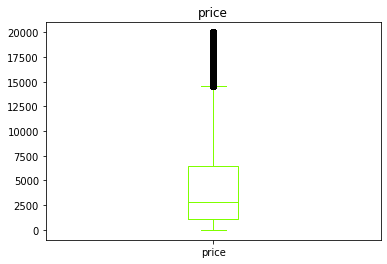

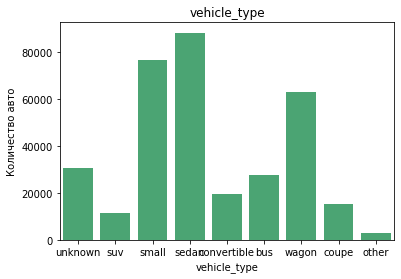

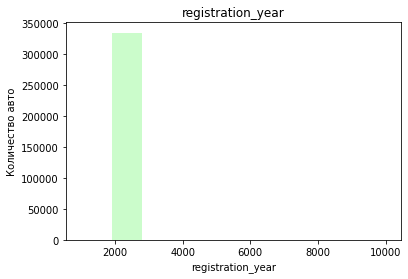

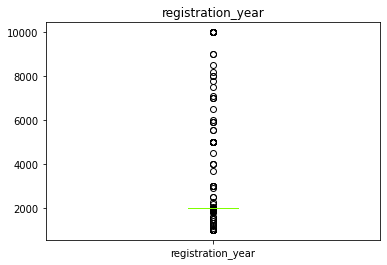

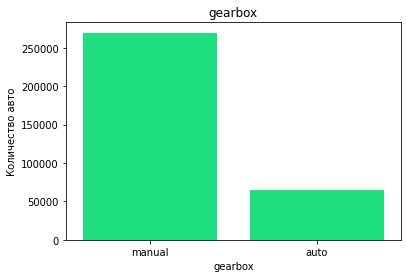

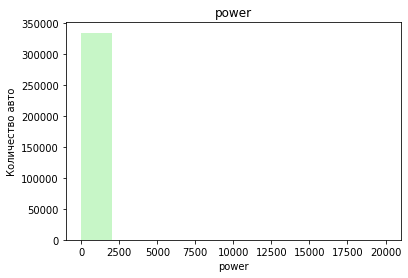

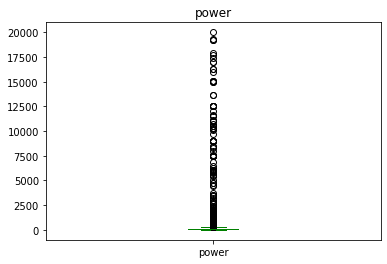

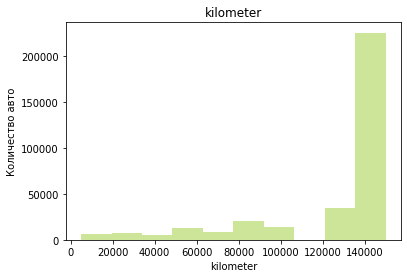

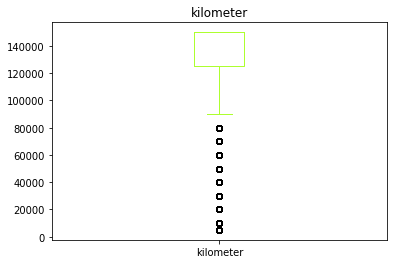

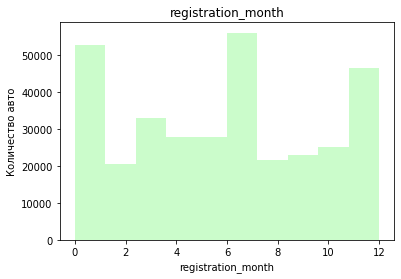

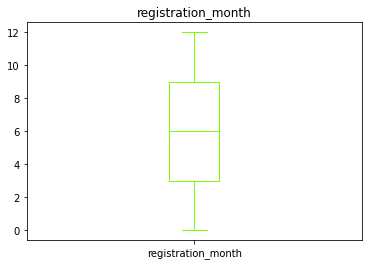

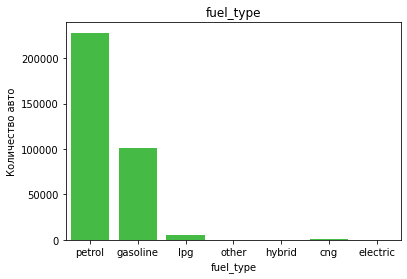

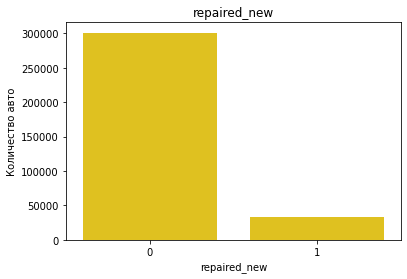

In [33]:
#применим их к каждому столбцу autos
for el in autos.columns:
    if el in col:
        visual(autos, el)
    elif el in cat_col:
        visual_cat(autos, el)

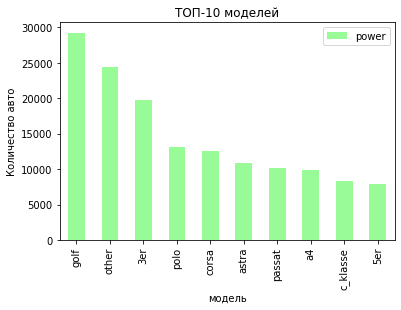

In [34]:
model = autos.pivot_table(index='model', values='power', aggfunc='count')\
        .sort_values(by='power', ascending=False).head(10)\
        .plot(kind='bar', title='ТОП-10 моделей', xlabel='модель', ylabel='Количество авто', color=np.random.choice(colors))

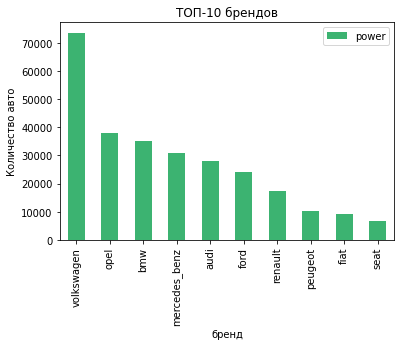

In [35]:
brand = autos.pivot_table(index='brand', values='power', aggfunc='count')\
        .sort_values(by='power', ascending=False).head(10)\
        .plot(kind='bar', title='ТОП-10 брендов', xlabel='бренд', ylabel='Количество авто', color=np.random.choice(colors))

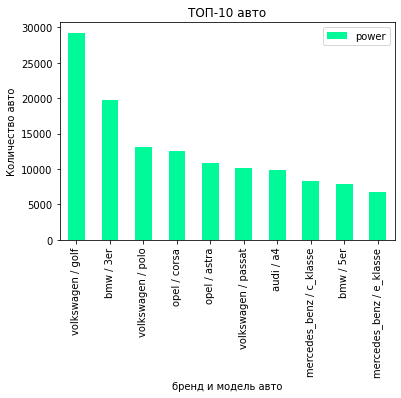

In [36]:
brand_model = autos.pivot_table(index='brand_model', values='power', aggfunc='count')\
        .sort_values(by='power', ascending=False).head(10)\
        .plot(kind='bar', title='ТОП-10 авто', xlabel='бренд и модель авто', ylabel='Количество авто', color=np.random.choice(colors))

По данным графиков:
1. Пик цены около 0. Если это не акция "машина за красивые глаза", надо поправить;
2. Год регистрации чаще всего - 2000 , но есть значения боьше/меньше. Из-за количество машин 2000 г.в. остальные года определены как выброс;
3. Лошадиные силы тоже показывают пик около 0 - непонятно, это маломощные машины перетянули или проблема в данных;
4. Чаще всего встречаются машины с пробегом, хотя новые тоже есть;
5. Любопытно, что месяц регистрации показывает июль, декабрь. Новогодние подарки и время отпусков позволяют чаще покупать машины? кстати, данные с неизвестным нулевым месяцев тоже есть. Подумаем над исключеним этого столбца в принципе, хоья протестировать его влияние надо - иногда ведь какие-то редкие машины с определенным выпуском могут стоить дороже. 
6. Подавляющее большинство машин не были в ремонте. Сомнительно, чтобы это был хороший показатель (во-первых, мы помним, что заменили пропуски на отсутствие ремонта; во-вторых среднестатичстическая машина 2000 г.в. без ремонта настораживает). Возможно, при построении моделей этот признак придется убрать.

Посмотрим на таблицу со статистическими данными

In [37]:
autos.describe()

,price,registration_year,power,kilometer,registration_month,repaired_new
count,334664.00,334664.00,334664.00,334664.00,334664.00,334664.00
mean,4504.35,2003.92,111.37,128562.59,5.81,0.10
std,4531.44,69.38,185.16,37205.93,3.69,0.30
min,0.00,1000.00,0.00,5000.00,0.00,0.00
25%,1150.00,1999.00,70.00,125000.00,3.00,0.00
50%,2800.00,2003.00,105.00,150000.00,6.00,0.00
75%,6500.00,2008.00,143.00,150000.00,9.00,0.00
max,20000.00,9999.00,20000.00,150000.00,12.00,1.00


начнем с цены. Сколько в выбоке бесплатных машин?

In [38]:
autos[autos['price'] == 0]['price'].count()

8588

~~Хотелось бы, конечно, ссылочку на этот сервис~~

Удаляем эти данные - это целевой признак и заменить его средним нецелесообразно.

In [39]:
autos = autos[autos['price'] != 0]

In [40]:
autos.shape

(326076, 13)

In [41]:
autos.describe()['price']

count   326076.00
mean      4622.98
std       4530.60
min          1.00
25%       1200.00
50%       2950.00
75%       6642.25
max      20000.00
Name: price, dtype: float64

Один евро за машину тоже маловероятная цена. Посмотрим, сколько вообще в выборке чересчур дешевых машин, например, меньше 50 евро.

In [42]:
autos[autos['price'] < 50]['price'].count()

1293

In [43]:
autos[(autos['price'] < 50) & (autos['price'] > 3)].sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired_new,brand_model
253276,2016-03-25 15:44:16,14,unknown,2000,auto,0,a6,150000,0,gasoline,audi,0,audi / a6
132279,2016-03-13 11:06:19,30,unknown,2005,auto,0,e_klasse,5000,0,gasoline,mercedes_benz,0,mercedes_benz / e_klasse
54718,2016-04-03 12:37:34,30,small,2000,manual,58,cuore,125000,4,petrol,daihatsu,0,daihatsu / cuore
143832,2016-03-06 19:41:58,40,unknown,1985,auto,0,e_klasse,150000,0,gasoline,mercedes_benz,0,mercedes_benz / e_klasse
237740,2016-03-05 20:37:25,20,unknown,2000,manual,0,v40,5000,0,petrol,volvo,0,volvo / v40
191299,2016-03-20 20:49:20,10,sedan,2003,manual,75,2_reihe,100000,6,petrol,peugeot,0,peugeot / 2_reihe
229809,2016-03-16 13:50:49,13,unknown,2012,manual,0,superb,5000,0,gasoline,skoda,0,skoda / superb
141679,2016-03-14 22:39:15,45,unknown,2014,manual,0,1er,5000,0,petrol,bmw,0,bmw / 1er
208192,2016-04-03 03:02:10,20,unknown,2017,manual,131,a4,5000,5,gasoline,audi,0,audi / a4
284756,2016-03-14 19:42:38,40,small,1997,manual,55,micra,150000,5,petrol,nissan,0,nissan / micra


Результаты кажутся маловероятными. Условный гольф 2016 года в пробегом 5000 за 29 евро кажется ошибкой в заполнении. 
Удалим машины стоимостью менее 50 евро.

In [44]:
autos = autos[autos['price'] > 50]
autos.shape

(324506, 13)

In [45]:
#посмотрим, сколько машин с мощностью 0
autos[autos['power'] == 0]['power'].count()

30633

Многовато. Заменим нулевые значения на моду по бренду+модели

In [46]:
# заменяем 0 в мощности на моду по бренду/модели
for t in autos['brand_model'].unique():
    power_mode = autos.loc[(autos['brand_model'] == t)]['power'].mode().values[0]
    autos.loc[(autos['brand_model'] == t) & (autos['power'] == 0), 'power'] = power_mode

In [47]:
#посмотрим, сколько машин с мощностью 0 осталось
autos[autos['power'] == 0]['power'].count()

2853

~~Кто ты, воин?~~

Скорее всего, это уникальное сочетание бренда+модели с незаполненной мощностью.


In [48]:
autos[autos['power'] == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired_new,brand_model
177,2016-03-22 10:55:42,300,bus,1997,manual,0,other,150000,7,petrol,opel,0,opel / other
243,2016-03-06 18:49:03,10200,coupe,2008,manual,0,other,90000,6,petrol,nissan,0,nissan / other
339,2016-03-09 20:45:43,3550,sedan,1993,manual,0,other,125000,11,petrol,chevrolet,0,chevrolet / other
407,2016-03-22 12:55:10,2200,bus,2000,manual,0,other,150000,3,gasoline,peugeot,0,peugeot / other
633,2016-03-12 22:57:06,1850,small,2003,manual,0,other,100000,1,petrol,peugeot,0,peugeot / other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353912,2016-03-05 20:43:30,800,unknown,1970,manual,0,other,150000,0,petrol,trabant,0,trabant / other
353930,2016-03-27 15:54:00,750,small,2001,manual,0,other,150000,0,petrol,hyundai,0,hyundai / other
354132,2016-03-07 19:46:36,2300,bus,2000,manual,0,other,80000,0,gasoline,citroen,0,citroen / other
354216,2016-03-19 14:59:31,790,unknown,1990,manual,0,other,150000,1,petrol,renault,0,renault / other


In [49]:
autos[autos['brand_model'] == 'land_rover / serie_1'] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired_new,brand_model
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,0,serie_1,30000,0,gasoline,land_rover,0,land_rover / serie_1


Так и есть. гугл подсказывает, что у этой модели обычно 52 лс. Пусть так  и будет

In [50]:
autos[autos['brand_model'] == 'land_rover / serie_1'].replace(0, 52)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired_new,brand_model
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,52,serie_1,30000,52,gasoline,land_rover,52,land_rover / serie_1


Посмотрим на значения мощности менее 10 л.с.

In [51]:
#посмотрим, сколько машин с мощностью 0 осталось
autos[autos['power'] < 10]['power'].count()

2908

In [52]:
autos[autos['power'] < 10].head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired_new,brand_model
177,2016-03-22 10:55:42,300,bus,1997,manual,0,other,150000,7,petrol,opel,0,opel / other
243,2016-03-06 18:49:03,10200,coupe,2008,manual,0,other,90000,6,petrol,nissan,0,nissan / other
339,2016-03-09 20:45:43,3550,sedan,1993,manual,0,other,125000,11,petrol,chevrolet,0,chevrolet / other
407,2016-03-22 12:55:10,2200,bus,2000,manual,0,other,150000,3,gasoline,peugeot,0,peugeot / other
633,2016-03-12 22:57:06,1850,small,2003,manual,0,other,100000,1,petrol,peugeot,0,peugeot / other


Мерседес вряд ли знает о том, что выпустил машину с 1 л.с. Удалим эти данные, они явно заполнены некорректно


In [53]:
autos = autos[autos['power'] > 10]
autos.shape

(321591, 13)

Осталось разобраться с большим значением power, странным нулевым месяцем и максимальным годом регистрации. 

In [54]:
autos[autos['power'] > 5000].sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired_new,brand_model
87830,2016-03-15 21:55:11,2550,small,2004,auto,6226,fortwo,125000,5,petrol,smart,0,smart / fortwo
209786,2016-04-04 19:49:19,1200,sedan,2001,manual,6512,corsa,150000,12,petrol,opel,0,opel / corsa
62975,2016-03-27 18:47:59,2200,small,1999,manual,12012,polo,150000,3,petrol,volkswagen,0,volkswagen / polo
171089,2016-03-17 10:37:53,1750,sedan,2006,manual,6010,agila,90000,8,petrol,opel,0,opel / agila
159612,2016-03-24 02:58:01,1150,unknown,2016,manual,6011,polo,150000,5,petrol,volkswagen,0,volkswagen / polo
292167,2016-03-21 12:49:22,2000,bus,2003,manual,12512,zafira,150000,12,petrol,opel,0,opel / zafira
182911,2016-04-02 10:49:27,9000,unknown,2017,auto,9000,clk,150000,0,petrol,mercedes_benz,0,mercedes_benz / clk
277113,2016-03-19 16:49:47,2890,bus,2005,manual,9007,c_max,150000,2,petrol,ford,0,ford / c_max
205727,2016-03-12 11:43:29,4700,bus,1997,manual,10522,transporter,150000,0,gasoline,volkswagen,0,volkswagen / transporter
150676,2016-03-09 18:57:50,1700,wagon,1995,manual,17410,80,5000,0,petrol,audi,1,audi / 80


Ну вот и гольф с 9000 л.с. Взлетаем?

Нет, пожалуй, удалим данные ввиду их неправдоподобности 

In [55]:
autos = autos[autos['power'] < 5000]
autos.shape

(321521, 13)

In [56]:
# что насчет машин из будущего? 
autos[autos['registration_year'] > 2017].shape[0]


3240

In [57]:
# удаляем
autos = autos[autos['registration_year'] <= 2017]
autos.shape

(318281, 13)

In [58]:
autos['date_crawled'].dtypes

dtype('O')

In [59]:
pd.to_datetime(autos['date_crawled']).dt.year.max()

2016

In [60]:
autos = autos.drop(['date_crawled'], axis=1)

In [61]:
# сколкьо машин с некорректно заполненным месяцем?
autos[autos['registration_month'] == 0].shape[0]

25285

Многовато, но здесь уже медиана не справится. Посмотрим в дальнейшем, как повлияет на модель. Возможно, признак приется исключить

Посмотрим теперь на describe

In [62]:
autos.describe()

,price,registration_year,power,kilometer,registration_month,repaired_new
count,318281.00,318281.00,318281.00,318281.00,318281.00,318281.00
mean,4669.77,2003.14,119.77,128715.02,5.89,0.10
std,4541.05,9.34,66.89,36722.11,3.65,0.30
min,55.00,1000.00,11.00,5000.00,0.00,0.00
25%,1250.00,1999.00,75.00,125000.00,3.00,0.00
50%,2990.00,2003.00,110.00,150000.00,6.00,0.00
75%,6750.00,2007.00,147.00,150000.00,9.00,0.00
max,20000.00,2017.00,4700.00,150000.00,12.00,1.00


In [63]:
autos.duplicated().sum()

30893

In [64]:
autos.shape

(318281, 12)

In [65]:
autos = autos.drop_duplicates()
autos.shape

(287388, 12)

Уже лучше. 


Итак, в этом шаге мы:
1. Удалили машины стоимостью менее 50 евро как недостоверные;
2. Заменили нулевые значения мощности на моду по бренду+модели;
3. Удалили машины мощностью менее 10 л.с.;
4. Удалили машины с мощностью более 5000 л.с.;
5. Удалили машины с некорректно заполненным годом выпуска - старше 2024. 

### Корреляционный анализ

In [66]:
autos.dtypes

price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired_new           int64
brand_model           object
dtype: object

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'repaired_new']


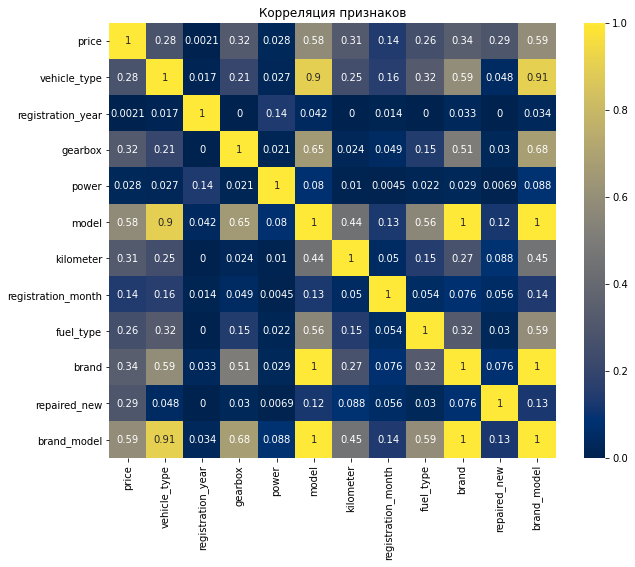

In [67]:
#посмотрим на коэффициенты корреляции между признаками
plt.figure(figsize=(10, 8))
sns.heatmap(autos.phik_matrix(), annot=True, cmap='cividis')
plt.title('Корреляция признаков');

In [68]:
interval_cols = ['price', 'power', 'kilometer']

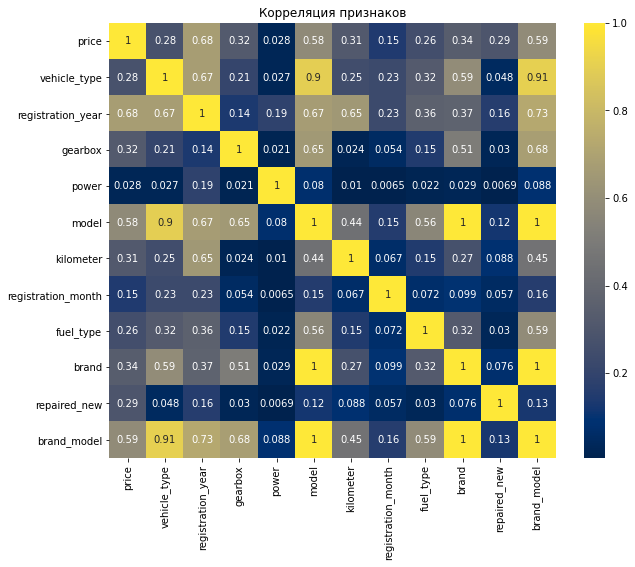

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(autos.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis')
plt.title('Корреляция признаков');

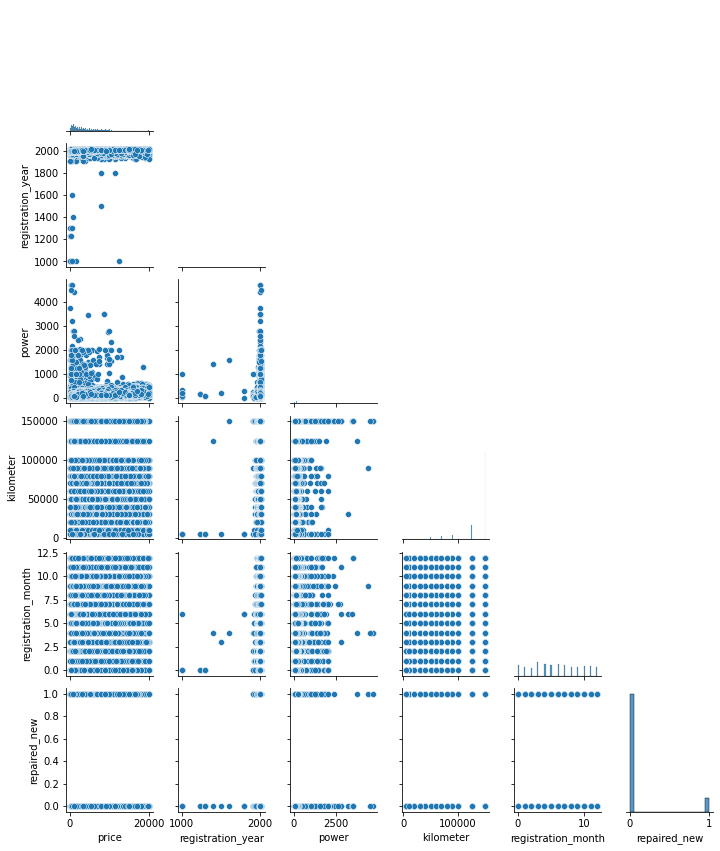

In [70]:
# построим диаграммы рассеяния для всех количественных признаков с учётом значения категориальных признаков.
sns.pairplot(
    data=autos, 
    aspect=.85,
    corner=True,
    height=2);

На этом шаге мы видим: 
* целевой признак коррелирует с годом регистрации, моделью (и бренд+модель, соответственно) больше всего;
* мощность и километраж тоде оказывают влияние на цену;
* в теории мы могли бы заменить километраж на категории до 100 тыс. км, 100-150 тыс. км и более 150 тыс км. Посмотрим в моделях, если потребуется улучшение, можно попробовать;
* впрочем, как и год выпуска: до 2000 г.в и после 2000 г.в.

По логике бренд + модель + год выпуска или километраж тоже должны хорошо коррелировать с ценой, если линейная регрессия будет показывать недостаточное качество, подумаем о добавлении такого признака. 

## Обучение моделей

Попроубем обучить несколько моделей: линейную регрессию, дерево и LightGBM.
Для начала обработаем данные

In [71]:
# разделим данные на выборки 
X = autos.drop(columns='price')
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [72]:
# создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'brand_model']
ord_columns = ['repaired_new']
num_columns = ['registration_year', 'power', 'kilometer', 'registration_month']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(handle_unknown='ignore'))]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('ord',  OrdinalEncoder(
                categories=[
                    ['0', '1']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Попробуем в линейной регрессии несколько скаляров. 

In [73]:
# запустим поиск лучших параметров для LinearRegression
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    #random_state=RANDOM_STATE,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)



In [74]:
%%time
grid.fit(X_train, y_train)

CPU times: user 2min 20s, sys: 2min 22s, total: 4min 42s
Wall time: 4min 44s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'brand_model']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['0',
                                                                                                                      '1']],
                                                                                                         handle_unknown='use_enco...
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['repaired_new']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer',
                                                                          'registration_month'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=73))]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [75]:
grid.refit_time_

25.99855923652649

In [76]:
print('Лучшая модель и её качество:', -grid.best_score_)

Лучшая модель и её качество: 2931.1466828241682


In [77]:
%%time

# посмотрим на предсказание модели и ее качество 
y_test_pred = grid.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False) 
print(f'rmse = {rmse:.2f}')

rmse = 2915.84
CPU times: user 216 ms, sys: 3.14 ms, total: 219 ms
Wall time: 407 ms


Попробуем в DecisionTreeRegressor разные параметры 

In [78]:
%%time

param_grid5 = {
        'models__max_depth': distributions.IntDistribution(2, 11),
        'models__max_features': distributions.IntDistribution(2, 11),
        'models__min_samples_split': distributions.IntDistribution(2, 11),
        'models__min_samples_leaf': distributions.IntDistribution(1, 11)
}
    
oscv_all_add2 = OptunaSearchCV(
    pipe_final, 
    param_grid5, 
    cv=5,
    n_trials=25,
    error_score='raise',
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
) 

oscv_all_add2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', oscv_all_add2.best_estimator_)


[I 2024-02-14 15:46:19,671] A new study created in memory with name: no-name-e7046667-6e87-4fac-a7e9-13c82654d194
[I 2024-02-14 15:46:23,077] Trial 0 finished with value: -3887.3770406196345 and parameters: {'models__max_depth': 2, 'models__max_features': 7, 'models__min_samples_split': 2, 'models__min_samples_leaf': 8}. Best is trial 0 with value: -3887.3770406196345.
[I 2024-02-14 15:46:26,282] Trial 1 finished with value: -3891.617512970953 and parameters: {'models__max_depth': 3, 'models__max_features': 5, 'models__min_samples_split': 4, 'models__min_samples_leaf': 11}. Best is trial 0 with value: -3887.3770406196345.
[I 2024-02-14 15:46:29,501] Trial 2 finished with value: -3875.1061858399758 and parameters: {'models__max_depth': 2, 'models__max_features': 11, 'models__min_samples_split': 2, 'models__min_samples_leaf': 3}. Best is trial 2 with value: -3875.1061858399758.
[I 2024-02-14 15:46:32,807] Trial 3 finished with value: -3726.833434777328 and parameters: {'models__max_depth

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'brand_model']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               '1']],
                                                                         

In [79]:
print('Лучшая модель и её качество:', -oscv_all_add2.best_score_)

Лучшая модель и её качество: 3520.5882402807924


In [80]:
oscv_all_add2.refit_time_

0.662238359451294

In [76]:
# создаём списки с названиями признаков
ord_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'brand_model', 'repaired_new']
num_columns = ['registration_year', 'power', 'kilometer', 'registration_month']


# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('ord',  OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [80]:
param_grid6 = {
        'models__max_depth': distributions.IntDistribution(11, 21),
#         'models__max_features': distributions.IntDistribution(2, 11),
#         'models__min_samples_split': distributions.IntDistribution(2, 11),
#         'models__min_samples_leaf': distributions.IntDistribution(1, 11)
}
    
oscv_all_add3 = OptunaSearchCV(
    pipe_final2, 
    param_grid6, 
    cv=5,
    n_trials=25,
    error_score='raise',
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
) 



In [81]:
%%time

oscv_all_add3.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', oscv_all_add3.best_estimator_)

[I 2024-02-15 09:52:01,498] A new study created in memory with name: no-name-e2ea07c9-7db1-495f-8f02-a5d175306a04
[I 2024-02-15 09:52:06,347] Trial 0 finished with value: -1953.5405913249538 and parameters: {'models__max_depth': 11}. Best is trial 0 with value: -1953.5405913249538.
[I 2024-02-15 09:52:12,131] Trial 1 finished with value: -2003.3544320102017 and parameters: {'models__max_depth': 17}. Best is trial 0 with value: -1953.5405913249538.
[I 2024-02-15 09:52:16,952] Trial 2 finished with value: -1953.5405913249538 and parameters: {'models__max_depth': 11}. Best is trial 0 with value: -1953.5405913249538.
[I 2024-02-15 09:52:22,856] Trial 3 finished with value: -2031.1402623897598 and parameters: {'models__max_depth': 18}. Best is trial 0 with value: -1953.5405913249538.
[I 2024-02-15 09:52:27,905] Trial 4 finished with value: -1936.9570270353156 and parameters: {'models__max_depth': 12}. Best is trial 4 with value: -1936.9570270353156.
[I 2024-02-15 09:52:33,239] Trial 5 finis

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'brand_model',
                                                   'repaired_new']),
                       

In [82]:
print('Лучшая модель и её качество:', -oscv_all_add3.best_score_)

Лучшая модель и её качество: 1930.8122468971465


In [84]:
oscv_all_add3.refit_time_

1.1438677310943604

In [85]:
%%time

y_test_pred5 = oscv_all_add3.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred5, squared=False) 
print(f'rmse = {rmse:.2f}')

rmse = 1902.55
CPU times: user 176 ms, sys: 142 µs, total: 176 ms
Wall time: 174 ms


In [87]:
%%time

y_test_pred2 = oscv_all_add2.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred2, squared=False) 
print(f'rmse = {rmse:.2f}')

rmse = 3211.44
CPU times: user 206 ms, sys: 6.57 ms, total: 213 ms
Wall time: 218 ms


С LightGBM обработаем данные вручную. 

In [88]:
# делим датасет на выборки
X2 = autos.drop(['price', 'brand_model'], axis=1)
y2 = autos['price']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=TEST_SIZE, random_state=RANDOM_STATE)


#определяем количественные и категориальные значения 
cat_col_names = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand' ]
col_names = ['registration_year', 'power', 'kilometer', 'registration_month', 'repaired_new']


#кодируем категориальные признаки
# выберем класс OneHotEncoder() для кодирования 
encoder = OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=np.nan)

# обучаем и преобразовываем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train2[cat_col_names])
X_test_ohe = encoder.transform(X_test2[cat_col_names])

# сохраним в переменной encoder_col_names названия новых столбцов 
encoder_col_names = encoder.get_feature_names_out()

#масштабируем количественные признаки
# создаем переменную с экземпляром класса StandartScaler()
scaler = StandardScaler()

# обучаем и преобразовываем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train2[col_names])
X_test_scaled = scaler.transform(X_test2[col_names])


# соберем все в один датафрейм

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)


X_train2 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test2 = pd.concat([X_test_ohe, X_test_scaled], axis=1)



In [89]:
lgb_model = LGBMRegressor()

In [90]:

%%time

lgbm_params = {"n_estimators": [1000, 1100],
               "max_depth": [5, 11]
              }
grid5 = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=4,
                             scoring = 'neg_root_mean_squared_error',
                             n_jobs=-1,
                             verbose=False)

grid5.fit(X_train2, y_train2)



print('Лучшая модель и её параметры:\n\n', grid5.best_estimator_)

Лучшая модель и её параметры:

 LGBMRegressor(max_depth=11, n_estimators=1100)
CPU times: user 11min 41s, sys: 0 ns, total: 11min 41s
Wall time: 11min 46s


In [91]:
%%time

y_test_pred4 = grid5.predict(X_test2)
rmse = mean_squared_error(y_test, y_test_pred4, squared=False) 
print(f'rmse = {rmse:.2f}')

rmse = 1572.19
CPU times: user 7.28 s, sys: 0 ns, total: 7.28 s
Wall time: 7.26 s


In [92]:
print('Лучшая модель и её качество:', -grid5.best_score_)

Лучшая модель и её качество: 1583.6640344353873


In [93]:
grid5.refit_time_

42.96034479141235

## Анализ моделей

In [100]:
df = pd.DataFrame({'Модель': ['LinearRegression', 'DecisionTreeRegressor с OHE', 
                              'DecisionTreeRegressor с ORD', 'LGBMRegressor'],
                   'Wall time на обучении': ['4min 46s', '1min 23s', '1min 48s', '12min 28s'],
                   'refit_time_': [26.8, 0.68, 1.23, 41.2],
                   'Wall time на предсказании': ['400 ms', '219 ms', '199 ms', '7.31 s'],
                   'best_score_ на обучении': [2931.1, 3520.6,  1936.4, 1583.7],
                   'rmse на тестовых данных': [2915.84, 3211.44, 1931.77, 1572.19]                 
                  })

df

,Модель,Wall time на обучении,refit_time_,Wall time на предсказании,best_score_ на обучении,rmse на тестовых данных
0,LinearRegression,4min 46s,26.80,400 ms,2931.10,2915.84
1,DecisionTreeRegressor с OHE,1min 23s,0.68,219 ms,3520.60,3211.44
2,DecisionTreeRegressor с ORD,1min 48s,1.23,199 ms,1936.40,1931.77
3,LGBMRegressor,12min 28s,41.20,7.31 s,1583.70,1572.19


Для сравнения представлены четыре модели:
1. LinearRegression
2. DecisionTreeRegressor с OHE
3. DecisionTreeRegressor с ORD
4. LGBMRegressor


Исходя из предоставленных заказчиков вводных, по качеству проходят DecisionTreeRegressor с ORD и LightGBM. Однако DecisionTreeRegressor с ORD в разы быстрее учится и значительно быстрее выдает результат предсказаний. Предлагаю остановиться на DecisionTreeRegressor с ORD. Если же важнее улучшение качества за счет скорости, лучше выбрать LGBMRegressor.


## Общий вывод

1. На этапе загрузки выявлены проблемы:
* в данных много пропусков, 
* есть полные дубли, 
* есть несоответствие в типах данных.
2. Проблемы в данных устранены следующими методами:
* данные в столбце repaired приведены к типу 1/0;
* пропуски в столбце repaired заменены на 0 с предположением, что если данные о ремонте не заполнены, то ремонта не было;
* проспуски в vehicle_type заполнены заглушкой "unknown";
* пропуски в gearbox и fuel_type заполнены модой для сочетания бренд/модель;
* пропуски в модели удалены, т.к. значения в этом столбце влияют на качество заполнения пропусков в прочих;
* удалены неинформативные столбцы: repaired, date_crawled, date_created, number_of_pictures, postal_code, lastseen.
3. При исследовательнском анализе данных выявлено:
* Пик цены около 0. Удалены машины стоимостью менее 50 евро;
* Год регистрации чаще всего - 2000. Удалены значения старше 2024г;
* Лошадиные силы тоже показывают пик около 0. Нулевые значения заменены на моду по бренду+модели. Удалены оставшиеся значения менее 10 л.с.;
* Чаще всего встречаются машины с пробегом, хотя новые тоже есть;
4. При корреляционно анализе выявлено:
* целевой признак коррелирует с моделью (и бренд+модель, соответственно) больше всего;
* мощность и километраж тоже оказывают влияние на цену.
5. Для сравнения представлены четыре модели:
* LinearRegression
* DecisionTreeRegressor с OHE
* DecisionTreeRegressor с ORD
* LGBMRegressor

Исходя из предоставленных заказчиков вводных, по качеству проходят DecisionTreeRegressor с ORD и LightGBM. Однако DecisionTreeRegressor с ORD в разы быстрее учится и значительно быстрее выдает результат предсказаний. Предлагаю остановиться на DecisionTreeRegressor с ORD. Если же важнее улучшение качества за счет скорости, лучше выбрать LGBMRegressor.